### Імпортування бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
#import tensorflow as tf
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import datetime 

### Перевірка застосування графічного процесора

In [2]:
#check if GPU is available
#print(tf.config.list_physical_devices('GPU'))

### Завантажження данних у словник

In [3]:

data = {
    year: {
            "climate": nc.Dataset("data/main/" + year + "/climate.nc"),
            "polution": nc.Dataset("data/main/" + year + "/polution.nc"),
        }
    for year in ["2021", "2022", "2023"]
}

#### Кількість географічних точок на кліматичних данних і на данних про викидів різниться. 
#### Знаходжу спільні точки

In [4]:
pol_lat_2021 = np.array(data["2021"]["polution"].variables["latitude"][: :-1])
climate_lat_2021 = np.array(data["2021"]["climate"].variables['lat'][:])
sorter = np.argsort(pol_lat_2021)
lats = -1 - np.searchsorted(pol_lat_2021, climate_lat_2021, sorter=sorter)


pol_lon_2021 = np.array(data["2021"]["polution"].variables["longitude"][:])
climate_lon_2021 = np.array(data["2021"]["climate"].variables['lon'][:])
sorter = np.argsort(pol_lon_2021)
lons = np.searchsorted(pol_lon_2021, climate_lon_2021, sorter=sorter)

### Завантаження данних у множину датафреймів

In [5]:
start_date = datetime.date(2021, 1, 1); end_date = datetime.date(2023, 12, 31)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

DATA = {}

atributes_climate = list(data["2021"]["climate"].variables.keys())[:-3]
atributes_polution = list(data["2021"]["polution"].variables.keys())[4:]

for i in range(len(lats)):
    for j in range(len(lons)):

        i_p = lats[i]
        j_p = lons[j]

        _data = {
            atribute: np.array(data["2021"]["climate"].variables[atribute][:, i, j])
            for atribute in atributes_climate
        }

        for atribute in atributes_polution:
            _data[atribute] = np.array(data["2021"]["polution"].variables[atribute][:, 0, i_p, j_p])


        _data["time"] = time

        for year in ["2022", "2023"]:
            for atribute in atributes_climate:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["climate"].variables[atribute][:, 0, 0]))
            for atribute in atributes_polution:
                _data[atribute] = np.append(_data[atribute], np.array(data[year]["polution"].variables[atribute][:, 0, 0, -1]))
        
        DATA[str(float(data["2021"]["climate"].variables["lat"][i])) + "x" + str(float(data["2021"]["climate"].variables["lon"][j]))]= pd.DataFrame(_data)


In [6]:
DATA["52.25x36.75"]

,ALLSKY_SFC_SW_DWN,WD10M,WS50M,QV2M,WD50M,PS,WS10M,T2M,co_conc,no2_conc,no_conc,o3_conc,pm10_conc,pm2p5_conc,so2_conc,time
0,0.24,150.309998,8.16,3.00,151.339996,99.019997,6.13,-2.67,165.812546,2.094728,0.114966,45.673897,15.915214,14.042672,2.042157,2021-01-01
1,0.28,233.199997,7.21,2.90,233.759995,99.410004,4.68,-3.19,190.595673,4.180746,0.262915,26.774969,5.392114,4.794663,0.673026,2021-01-02
2,0.35,199.509995,6.09,2.22,199.919998,100.440002,3.83,-6.33,196.013351,1.417576,0.094587,53.645283,11.483358,10.168221,0.763421,2021-01-03
3,0.33,159.449997,6.69,2.39,160.139999,100.309998,4.63,-5.51,192.674072,2.827499,0.091319,54.002937,14.512181,12.881714,3.194430,2021-01-04
4,0.25,131.740005,6.58,2.33,132.389999,99.980003,4.35,-5.62,144.451233,1.084685,0.033161,65.768387,8.892210,7.685567,0.367649,2021-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090,1.92,249.639999,8.01,6.88,250.039993,101.879997,6.71,10.52,169.066650,1.973635,0.089216,56.505196,2.719846,2.470642,0.598573,2023-12-27
1091,1.71,133.110001,5.72,5.39,133.350006,102.760002,5.15,9.40,193.595978,2.935729,0.263832,55.377506,6.573823,5.748918,1.993840,2023-12-28
1092,1.97,241.759995,7.07,6.66,242.059998,102.000000,6.30,9.86,201.386597,2.816414,0.199975,43.828003,13.946591,11.377452,1.526470,2023-12-29
1093,1.38,246.309998,4.47,6.37,246.259995,101.849998,4.12,9.02,202.640991,2.945606,0.128082,47.272038,13.147657,11.454666,1.440309,2023-12-30


### Статистичні данні стосовно всіх видів викидів

In [90]:
stats = {
    atribute: np.array([])
    for atribute in atributes_polution
}
for val in DATA.values():
    for atribute in atributes_polution:
        stats[atribute] = np.append(stats[atribute], val[atribute])

### Візуалізація "сирих" данних

In [92]:
ranges = [[100, 450], [0, 8], [0, 1], [0, 130], [0, 50], [0, 25], [0, 7]]

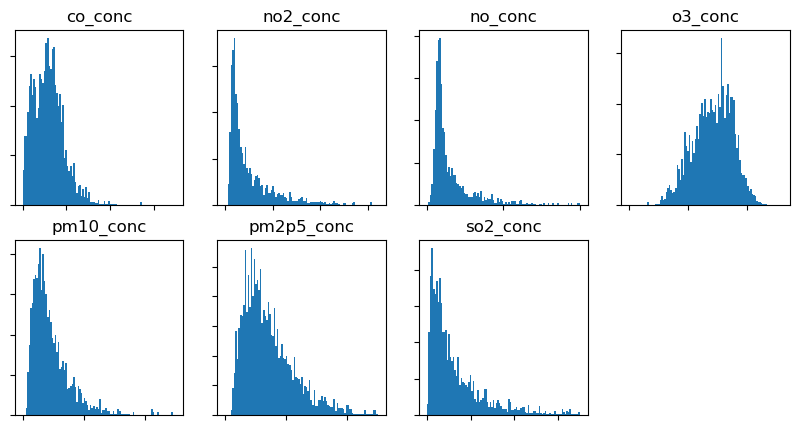

In [122]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in stats.keys():
    stat = stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100, range= _range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

In [128]:
np.max(stats["no_conc"])

31.482698440551758

In [107]:
import seaborn

<Axes: >

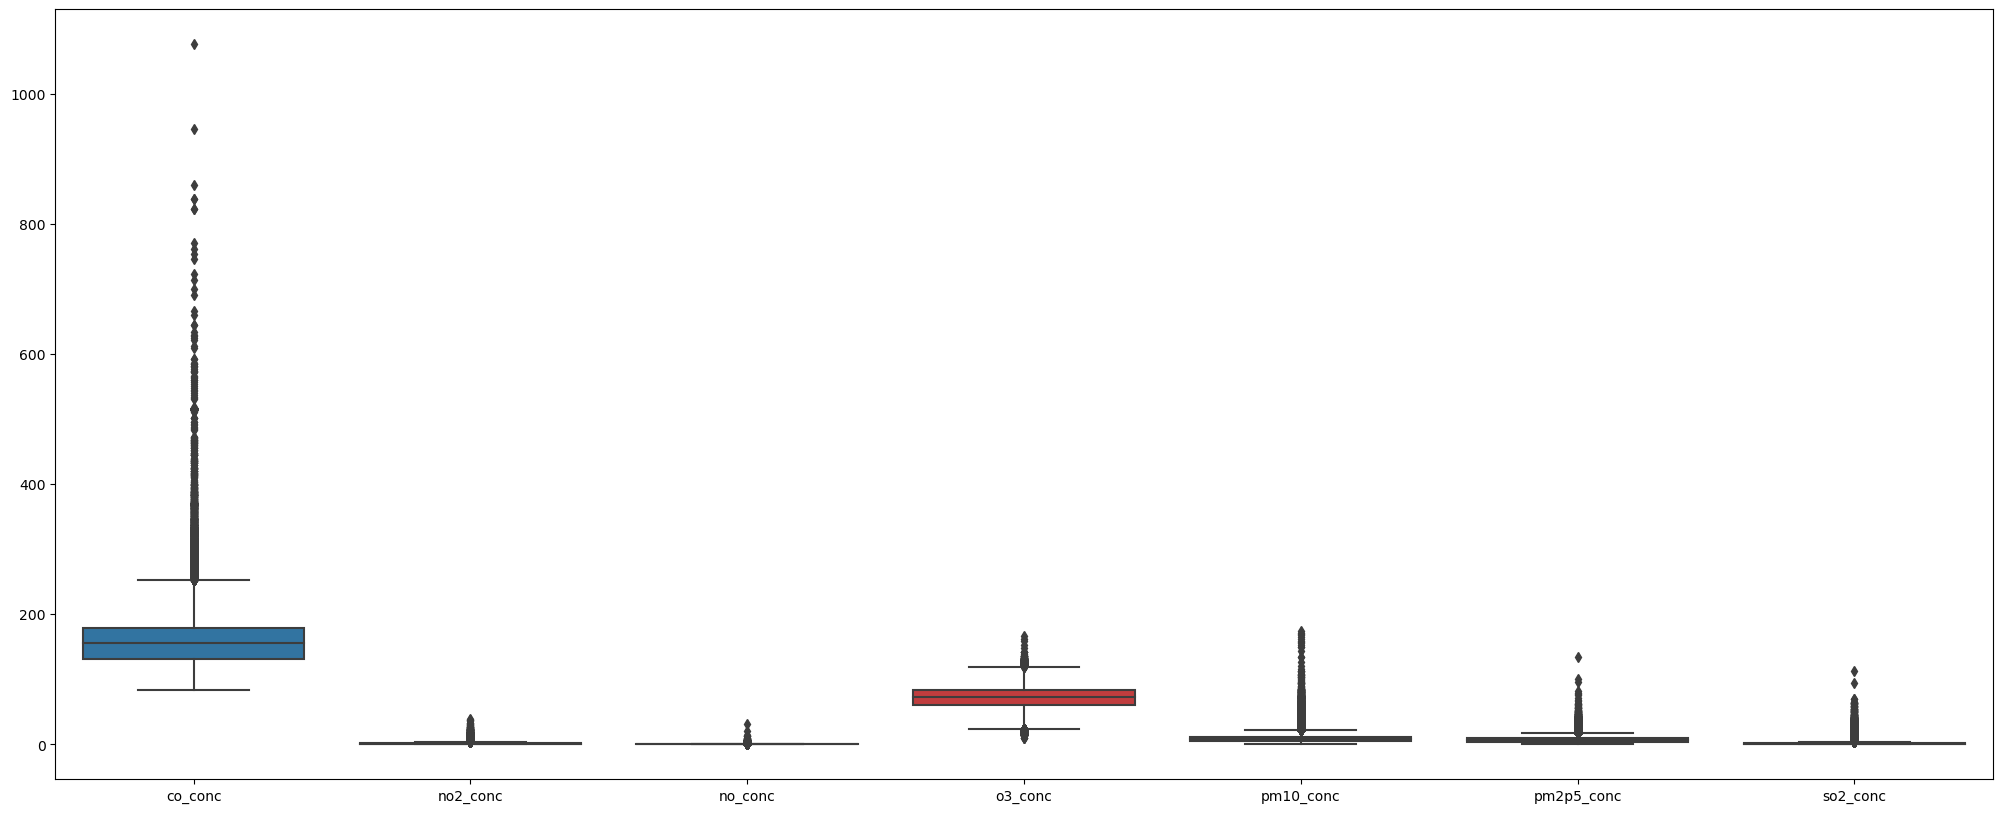

In [120]:
plt.figure(figsize=(25,10))
seaborn.boxplot(data=pd.DataFrame(stats))

In [145]:
np.sum(stats["no_conc"] > 12)

6

### Нормалізація данних

In [43]:
normal_stats = {}
for atribute in stats.keys():
    temp = stats[atribute]
    temp = temp - np.min(temp)
    normal_stats[atribute] = temp / np.max(temp)

In [52]:
ranges = [[0, 0.2], [0, 0.15], [0, 0.02], [0, 0.65], [0, 0.18], [0, 0.2], [0, 0.06]]

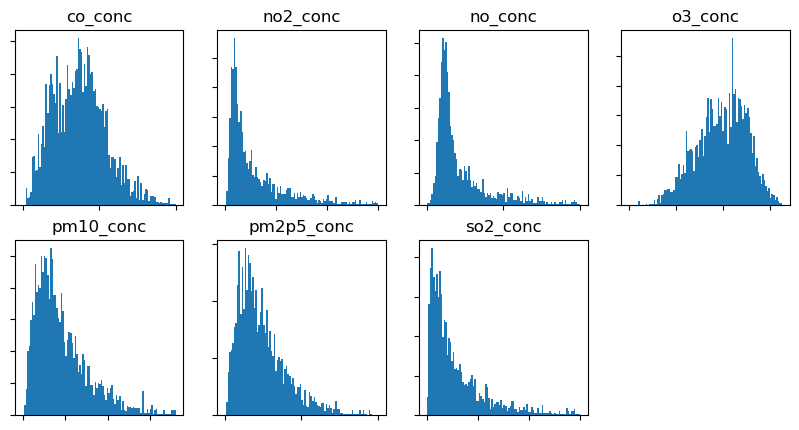

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in normal_stats.keys():
    stat = normal_stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

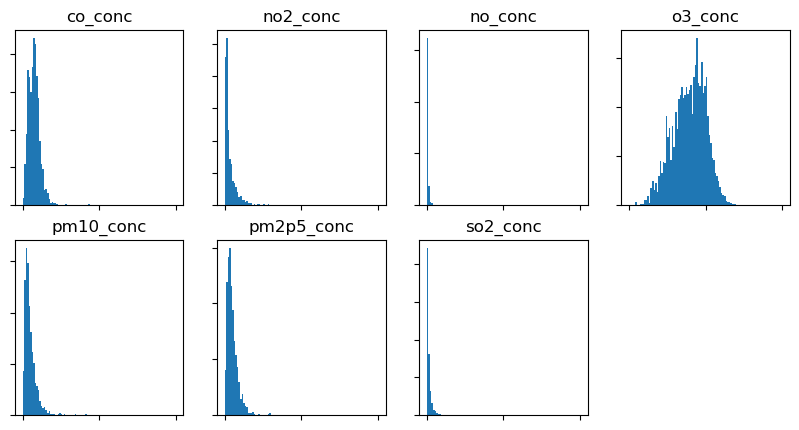

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in normal_stats.keys():
    stat = normal_stats[label]
    ax = axes[i]
    _range = [0, 1]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

### Застосування логарифмічної функції: $\log(1 + x)$

In [54]:
log_stats = {}
for atribute in normal_stats.keys():
    temp = np.log(1 + stats[atribute])
    temp = temp - np.min(temp)
    log_stats[atribute] = temp / np.max(temp)

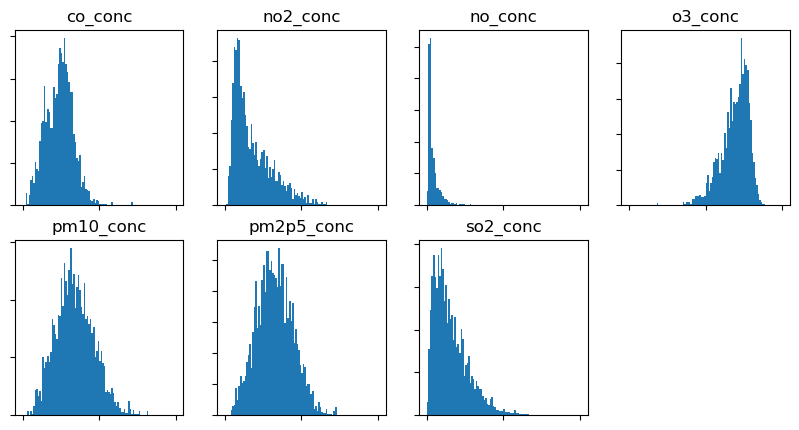

In [67]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in log_stats.keys():
    stat = log_stats[label]
    ax = axes[i]
    _range = [0, 1]
    i+=1
    ax.hist(np.array(stat), bins=100, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

In [64]:
ranges = [[0, 0.5], [0, 0.7], [0, 0.18], [0.4, 0.9], [0, 0.8], [0, 0.72], [0, 0.6]]

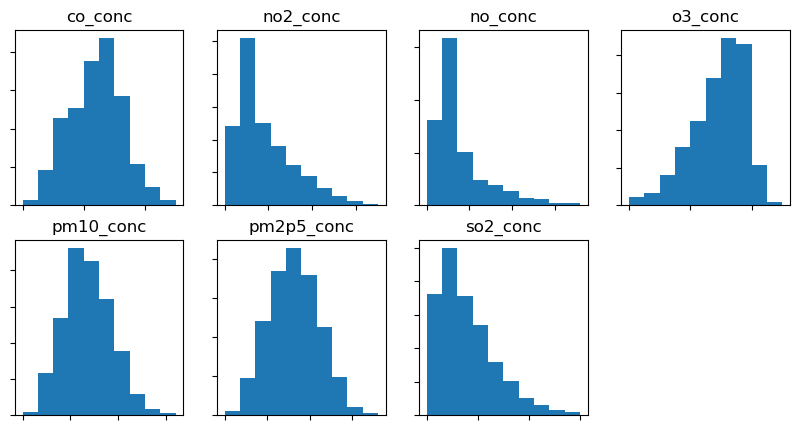

In [76]:
fig, axes = plt.subplots(2, 4, figsize=(2.5 * 4, 2.5 * 2))
axes = np.array(axes).flatten()
i = 0
for label in log_stats.keys():
    stat = log_stats[label]
    ax = axes[i]
    _range = ranges[i]
    i+=1
    ax.hist(np.array(stat), bins=10, range=_range)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(label)
axes[-1].set(visible=False)
plt.show()

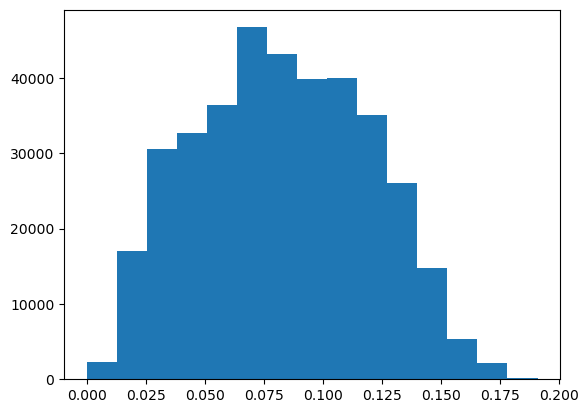

In [87]:
plt.hist(np.log(1 +np.log(1 +np.log(1 +np.log(1 +np.log(1 + np.log(1 +     np.log(1 + np.log(1 + np.log(1 + log_stats["so2_conc"]))))))))), bins = 15)
plt.show()

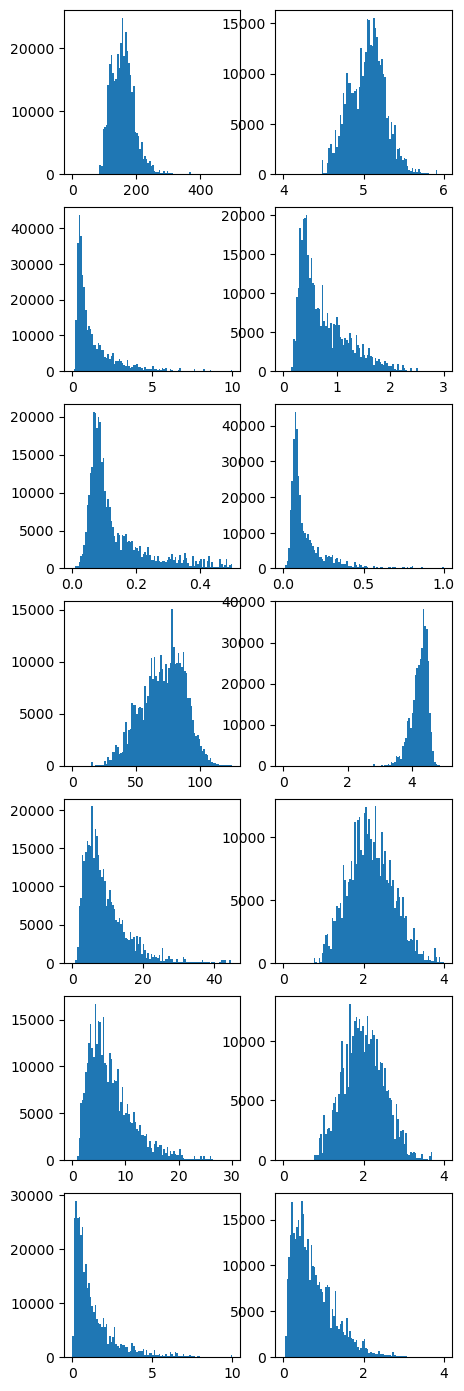

In [64]:

fig, axes = plt.subplots(len(stats), 2, figsize=(5, 2.5 * len(stats)))

i = 0
for stat in stats.values():
    ax1, ax2 = axes[i]
    range1, range2 = ranges[i]
    i+=1
    ax1.hist(np.array(stat), bins=100, range = range1)
    ax2.hist(np.log(1 + stat), bins=100, range = range2)
plt.show()

In [19]:
ds = nc.Dataset('data/4/adaptor.cams_regional_fc.retrieve-1716019478.8230424-19030-9-641f1c8d-5acb-4368-ba1f-f0fb747895f2.nc')

In [33]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    title: CO/NO2/O3/PM10/PM25/SO2 Air Pollutant ANALYSIS at the Surface
    institution: Data produced by Meteo France
    source: Data from ENSEMBLE model
    history: Model ENSEMBLE ANALYSIS
    ANALYSIS: Europe, 20230416-20240416+[12H_12H]
    summary: ENSEMBLE model hourly ANALYSIS of CO/NO2/O3/PM10/PM25/SO2 concentration at the Surface from 20230416-20240416+[12H_12H] on Europe
    project: MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)
    dimensions(sizes): longitude(5), latitude(2), level(1), time(367)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 level(level), float32 time(time), float32 co_conc(time, level, latitude, longitude), float32 no2_conc(time, level, latitude, longitude), float32 o3_conc(time, level, latitude, longitude), float32 pm10_conc(time, level, latitude, longitude), float32 pm2p5_conc(time, level, latitude, longitude),

In [99]:
ds.variables["co_conc"]

<class 'netCDF4._netCDF4.Variable'>
float32 co_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Carbon Monoxide
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_carbon_monoxide_in_air
unlimited dimensions: time
current shape = (367, 1, 2, 5)
filling on

In [34]:
ds.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'co_conc', 'no2_conc', 'o3_conc', 'pm10_conc', 'pm2p5_conc', 'so2_conc'])

In [72]:
start_date = datetime.date(2023, 4, 16)
end_date = datetime.date(2024, 4, 16)
time = [start_date + datetime.timedelta(days=i) for i in range((end_date - start_date).days + 1)]

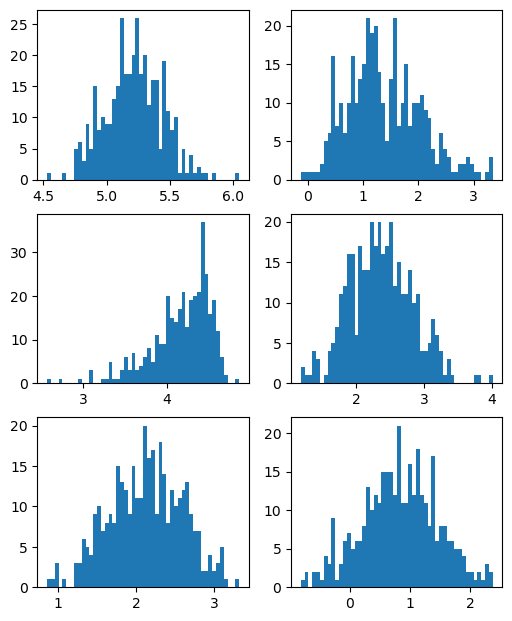

In [98]:
fig, axes = plt.subplots(3, 2, figsize=(6, 7.5)) 
polut = ['co_conc', 'no2_conc', 'o3_conc', 'pm10_conc', 'pm2p5_conc', 'so2_conc']

for i, ax in enumerate(axes.flat):
    ax.hist(np.log(ds.variables[polut[i]][:, 0, 0, 0 ]), bins=50)
plt.show()

In [ ]:
data = {
    "time": time, 
    "cords": 


    for i, lat in enumerate(ds.variables['lat'][:])
    for j, lon in enumerate(ds.variables['lon'][:])
}

In [95]:
axes.flat[1]

<Axes: >

In [74]:
for i in range(367):
    if np.log(ds.variables['co_conc'][i, 0, 0, 0]) > 6:
        print(time[i])


2023-11-08


netcdf

In [3]:
ds = nc.Dataset('data/3/adaptor.cams_regional_fc.retrieve-1711784804.7831938-5284-8-7a022bcb-9f4b-476b-ada5-450f77a5b403.nc')
ds_1 = nc.Dataset('data/3/temprature_wind/POWER_Point_Daily_20240301_20240328_050d4500N_030d3500E_LST.nc')

In [4]:
ds.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [5]:
ds_1.variables.keys()

dict_keys(['T2M', 'WS10M', 'time', 'lat', 'lon'])

In [6]:
ds["longitude"][:]

masked_array(data=[30.35, 30.45, 30.55, 30.65, 30.75],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [8]:
O3 = ds["o3_conc"][:, 0, 0, 0].data

In [9]:
wind = ds_1["WS10M"][:].data.T[0,0]

In [10]:

temp = ds_1["T2M"][:].data.T[0,0]

In [11]:
print(len(O3))
print(len(wind))
print(len(temp))

28
28
28


In [23]:
params = np.array([wind, temp]).T

In [24]:
model = LinearRegression().fit(params[:27], O3[:27])

In [16]:
model.coef_

array([0.5173282 , 0.47848004], dtype=float32)

In [14]:
model.intercept_

59.62824

In [18]:
model.coef_[0] * wind[-1] + model.coef_[1] * temp[-1] + model.intercept_

67.64603

In [21]:
model.predict([[wind[-1], temp[-1]]])

array([67.64603], dtype=float32)

In [26]:
prediction = np.array(model.predict(params))

In [22]:
O3[27]

79.495834

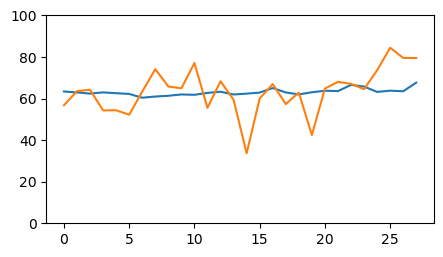

In [33]:
fig, ax = plt.subplots(figsize=(5, 2.7))
ax.plot(prediction)
ax.plot(O3)
ax.set_ylim([0, 100])
plt.show()

In [47]:
print("max difference = ", np.max(np.abs(prediction - O3)), "=", np.max(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% "
      "mean difference = " ,np.mean(np.abs(prediction - O3)), "=" , np.mean(np.abs(prediction - O3)) / np.mean(np.abs(prediction - O3)), "% ")

max difference =  28.688492 = 3.7122946 % mean difference =  7.7279673 = 1.0 % 


Kaggle

In [48]:
df = pd.read_csv('data/kaggle/onehr.data.xls')

In [18]:
df.columns = ["Date","WSR0","WSR1","WSR2","WSR3","WSR4","WSR5","WSR6","WSR7","WSR8","WSR9","WSR10","WSR11","WSR12","WSR13","WSR14","WSR15","WSR16","WSR17","WSR18","WSR19","WSR20","WSR21","WSR22","WSR23","WSR_PK","WSR_AV","T0","T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T_PK","T_AV","T85","RH85","U85","V85","HT85","T70","RH70","U70","V70","HT70","T50","RH50","U50","V50","HT50","KI","TT","SLP","SLP_","Precp","Target"]

In [19]:
df

,Date,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,Target
0,1/2/1998,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,...,0.48,8.39,3.84,5805,14.05,29,10275,-55,0,0.0
1,1/3/1998,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,...,0.6,6.94,9.8,5790,17.9,41.3,10235,-40,0,0.0
2,1/4/1998,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,...,0.49,8.73,10.54,5775,31.15,51.7,10195,-40,2.08,0.0
3,1/5/1998,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,...,?,?,?,?,?,?,?,?,0.58,0.0
4,1/6/1998,3.1,3.5,3.3,2.5,1.6,1.7,1.6,1.6,2.3,...,0.09,11.98,11.28,5770,27.95,46.25,10120,?,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2530,12/27/2004,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,...,0.07,7.93,-4.41,5800,-25.6,21.8,10295,65,0,0.0
2531,12/28/2004,1,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,...,0.04,5.95,-1.14,5845,-19.4,19.1,10310,15,0,0.0
2532,12/29/2004,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,...,0.06,7.8,-0.64,5845,-9.6,35.2,10275,-35,0,0.0
2533,12/30/2004,1.3,0.9,1.5,1.2,1.6,1.8,1.1,1,1.9,...,0.25,7.72,-0.89,5845,-19.6,34.2,10245,-30,0.05,0.0


In [20]:
data = nc.Dataset('data/2/adaptor.cams_regional_fc.retrieve-1706511910.699155-19398-7-0139e086-561b-430a-ad16-805bf0c3497a.nc')

In [21]:
data.variables.keys()

dict_keys(['longitude', 'latitude', 'level', 'time', 'o3_conc'])

In [22]:
data['o3_conc']

<class 'netCDF4._netCDF4.Variable'>
float32 o3_conc(time, level, latitude, longitude)
    _FillValue: -999.0
    species: Ozone
    units: µg/m3
    value: hourly values
    standard_name: mass_concentration_of_ozone_in_air
unlimited dimensions: time
current shape = (1, 10, 3, 3)
filling on

In [23]:
data['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (3,)
filling on, default _FillValue of 9.969209968386869e+36 used

In [24]:
data['level']

<class 'netCDF4._netCDF4.Variable'>
float32 level(level)
    long_name: level
    units: m
unlimited dimensions: 
current shape = (10,)
filling on, default _FillValue of 9.969209968386869e+36 used